In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import seaborn as sns
import matplotlib.pyplot as plt


In the following block synthetic dataset is generated

In [3]:
np.random.seed(42)

# Parameters
n_months = 24
products = ["Dog Toys", "Cat Toys"]
months = pd.date_range(start="2023-01-01", periods=n_months, freq='MS')

# Marketing event date
event_date_original = pd.to_datetime('2024-10-01')
model_start_date = pd.to_datetime('2024-01-01')
model_end_date = pd.to_datetime('2025-01-01') 

# Base dataframe
df = pd.DataFrame([(month, product) for month in months for product in products],
                  columns=["Month", "Product"])

# Add month number for seasonality
df["Month_Num"] = df["Month"].dt.month

# Seasonality: smooth wave + December holiday bump
df["Seasonality"] = 500 * np.sin((df["Month_Num"] - 1) / 12 * 2 * np.pi)
df["HolidayBump"] = np.where(df["Month_Num"] >= 11, 1000, 0)

# Add randomness and slight product-level difference
df["BaseRevenue"] = 10000
df["ProductGapBaseline"] = df["Product"].map({"Dog Toys": 200, "Cat Toys": 0})
df["Noise"] = np.random.normal(0, 50, size=len(df))


***This is the effect of the treatment: 
an extra $1000 monthly revenue for dog toys in Q4 2024 


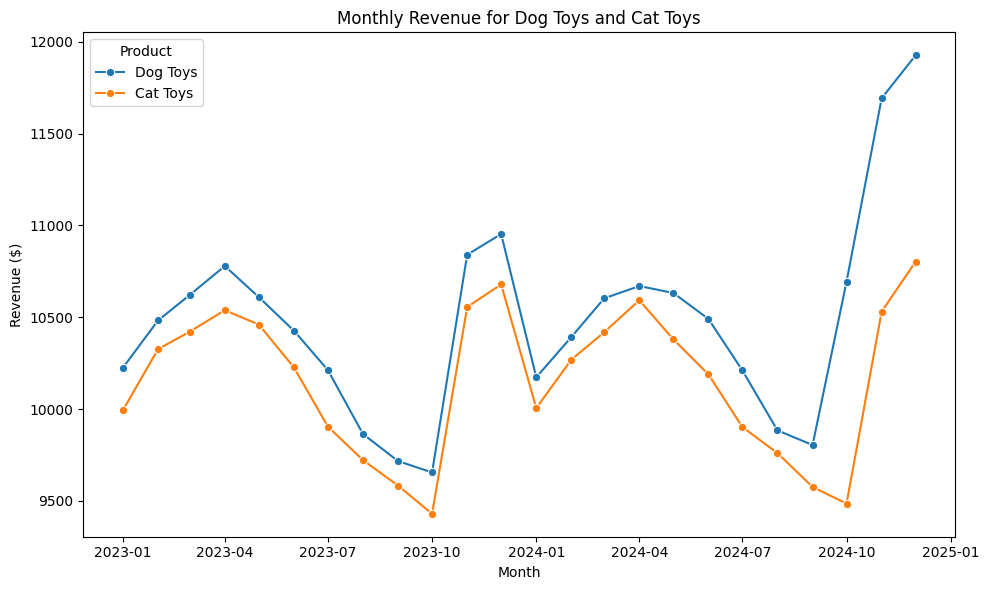

In [4]:
df['BetterPhotos'] = np.where((df['Product']=='Dog Toys') & (df['Month'] >= event_date_original), 1000, 0)

# Final revenue
df["Revenue"] = (
    df["BaseRevenue"]
    + df["ProductGapBaseline"]
    + df["Seasonality"]
    + df["HolidayBump"]
    + df["BetterPhotos"]
    + df["Noise"]
)

# Visualize the time series
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Month", y="Revenue", hue="Product", marker="o")
plt.title("Monthly Revenue for Dog Toys and Cat Toys")
plt.ylabel("Revenue ($)")
plt.tight_layout()
plt.show()


In [5]:
# Final output DataFrame
df = df[["Month", "Product", "Revenue"]]

########################################################
#Paralell Trends Assumption Test:
########################################################

subset = df.loc[df['Month'] < event_date_original].copy()

subset['trend'] = (subset['Month'].dt.year - event_date_original.year)*12 + (subset['Month'].dt.month - event_date_original.month)
subset['treated'] = np.where(subset['Product']=='Dog Toys',1,0)
subset['treated_trend'] = subset['treated'] * subset['trend']

formula = "Revenue ~ treated + trend + treated_trend"
model = smf.ols(formula, data=subset).fit()
print(model.summary())
print(f"Estimated Difference in Trends: {model.params['treated_trend']}")
print(f"P-value: {model.pvalues['treated_trend']}")

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.431
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.249
Time:                        16:08:21   Log-Likelihood:                -307.28
No. Observations:                  42   AIC:                             622.6
Df Residuals:                      38   BIC:                             629.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.001e+04    173.195     57.824

In [6]:
########################################################
#Placebo Test:
########################################################
placebo_event_date = pd.to_datetime('2024-07-01') 
placebo_start_date = pd.to_datetime('2023-07-01')
placebo_end_date = pd.to_datetime('2024-10-01')

subset_df = df.loc[(df['Month']>=placebo_start_date) & (df['Month']<placebo_end_date)].copy()

subset_df['post'] = subset_df['Month'].apply(lambda x: 1 if x>= placebo_event_date else 0)
subset_df['treated'] = np.where(subset_df['Product']=='Dog Toys', 1,0)
subset_df['treated_post'] = subset_df['post'] * subset_df['treated']

formula = 'Revenue ~ treated + post + treated_post'

model = smf.ols(formula, data = subset_df).fit()
print(model.summary())
print(f"Estimated Monthly Effect:{model.params['treated_post']: 0.1f}")


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.259
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.105
Time:                        16:08:22   Log-Likelihood:                -219.86
No. Observations:                  30   AIC:                             447.7
Df Residuals:                      26   BIC:                             453.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.014e+04    114.305     88.745   

In [8]:
# PLACEBO TESTS WITH SHUFFLED TREATMENT DATES:

placebo_results = []
possible_dates = df['Month'].unique()
placebo_pool = [d for d in possible_dates if d < event_date_original]

for i in range(len(placebo_pool)):
    fake_date = np.random.choice(placebo_pool)
    
    # Temp dataframe for this iteration
    temp_df = df.copy()
    temp_df['post'] = np.where(temp_df['Month'] >= fake_date, 1, 0)
    temp_df['treated'] = np.where(temp_df['Product'] == 'Dog Toys', 1, 0)
    temp_df['interaction'] = temp_df['post'] * temp_df['treated']
    
    res = smf.ols('Revenue ~ post + treated + interaction', data=temp_df).fit()
    placebo_results.append(res.params['interaction'])


In [9]:
########################################################
# Difference-in-Differences Model:
########################################################
df['treated'] = (df['Product'] == 'Dog Toys').astype(int)
df['post'] = (df['Month'] >= event_date_original).astype(int)
df['post_treated'] = df['treated'] * df['post']

subset = df[(df['Month'] >= model_start_date) & (df['Month'] < model_end_date)].copy()
formula = 'Revenue ~ treated + post + post_treated'
model = smf.ols(formula, data=subset).fit()
print(model.summary())

real_treatment_effect = model.params['post_treated']
did_effect = subset['post_treated'] * model.params['post_treated']
print(f"Avg Monthly Effect:{did_effect.sum()/subset['post_treated'].sum() : 0.1f}")


                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     7.580
Date:                Wed, 18 Feb 2026   Prob (F-statistic):            0.00141
Time:                        16:10:21   Log-Likelihood:                -176.89
No. Observations:                  24   AIC:                             361.8
Df Residuals:                      20   BIC:                             366.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.012e+04    140.326     72.127   

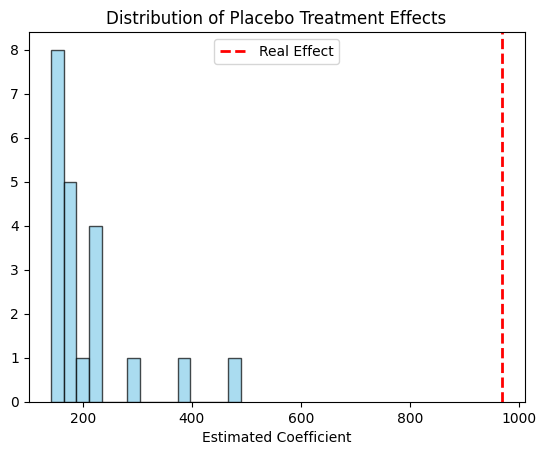

In [10]:
# Plotting
plt.hist(placebo_results, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(real_treatment_effect, color='red', linestyle='dashed', linewidth=2, label='Real Effect')
plt.title('Distribution of Placebo Treatment Effects')
plt.xlabel('Estimated Coefficient')
plt.legend()
plt.show()